# Stable Diffusion with KerasCV and OpenVINO

<div class="alert alert-block alert-danger"> <b>Important note:</b> This notebook requires python >= 3.9. Please make sure that your environment fulfill to this requirement  before running it </div>

Stable Diffusion is a powerful, open-source text-to-image generation model. There are multiple implementations of this pipeline in different frameworks. Previously, we already considered how to convert and optimize [PyTorch Stable Diffusion using HuggingFace Diffusers library](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/notebooks/stable-diffusion-text-to-image/stable-diffusion-text-to-image.ipynb). In this tutorial, we consider how to convert and run [Stable Diffusion from KerasCV](https://www.tensorflow.org/tutorials/generative/generate_images_with_stable_diffusion) that employs graph mode execution, which enhances performance by leveraging graph optimization and enabling parallelism and in the same time maintains a user-friendly interface for image generation. An additional part demonstrates how to run optimization with [NNCF](https://github.com/openvinotoolkit/nncf/) to speed up pipeline.

#### Table of contents:
 - [Prerequisites](#Prerequisites)
 - [Convert Stable Diffusion Pipeline models to OpenVINO](#Convert-Stable-Diffusion-Pipeline-models-to-OpenVINO)
    - [Convert text encoder](#Convert-text-encoder)
    - [Convert diffusion model](#Convert-diffusion-model)
    - [Convert decoder](#Convert-decoder)
 - [Stable Diffusion Pipeline with OpenVINO](#Stable-Diffusion-Pipeline-with-OpenVINO)
 - [Quantization](#Quantization)
    - [Prepare calibration dataset](#Prepare-calibration-dataset)
    - [Run Quantization](#Run-Quantization)
    - [Run Weight Compression](#Run-Weight-Compression)
    - [Compare model file sizes](#Compare-model-file-sizes)
    - [Compare inference time of the FP16 and INT8 pipelines](#Compare-inference-time-of-the-FP16-and-INT8-pipelines)
 - [Interactive Demo](#Interactive-Demo)
### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/stable-diffusion-keras-cv/stable-diffusion-keras-cv.ipynb" />


### Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
import platform

%pip install -q "tensorflow-macos>=2.15; sys_platform == 'darwin' and platform_machine == 'arm64' and python_version > '3.8'" # macOS M1 and M2
%pip install -q "tensorflow>=2.15; sys_platform == 'darwin' and platform_machine != 'arm64' and python_version > '3.8'" # macOS x86
%pip install -q "tensorflow>=2.15; sys_platform != 'darwin' and python_version > '3.8'"
%pip install -q keras-cv tf_keras numpy "openvino>=2024.1.0" "gradio>=4.19" datasets "nncf>=2.10.0"


if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

### Convert Stable Diffusion Pipeline models to OpenVINO

[back to top ⬆️](#Table-of-contents:)

Stable Diffusion consists of three parts:

- A text encoder, which turns your prompt into a latent vector.
- A diffusion model, which repeatedly "denoises" a 64x64 latent image patch.
- A decoder, which turns the final 64x64 latent patch into a higher-resolution 512x512 image.


![workflow-diagram](https://github.com/openvinotoolkit/openvino_notebooks/assets/67365453/2d7950a3-5bad-4670-897b-4d5327278feb)

Let us convert each model to OpenVINO format.

Import required modules and set constants

In [ ]:
import os

os.environ["TF_USE_LEGACY_KERAS"] = "1"

import keras_cv
import openvino as ov
import numpy as np
from pathlib import Path
import requests

# Fetch `notebook_utils` module
r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py")
open("notebook_utils.py", "w").write(r.text)
from notebook_utils import download_file

IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512
BATCH_SIZE = 1
MAX_PROMPT_LENGTH = 77


OV_TEXT_ENCODER_MODEL_PATH = Path("models/ov_text_encoder_model.xml")
OV_DIFFUSION_MODEL_PATH = Path("models/ov_diffusion_model.xml")
OV_DECODER_MODEL_PATH = Path("models/ov_decoder_model.xml")

Create KerasCV Stable Diffusion pipeline

In [ ]:
pipeline = keras_cv.models.StableDiffusion(img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT)

#### Convert text encoder

[back to top ⬆️](#Table-of-contents:)

Text encoder has 2 inputs: `tokens` and `positions`. Specify inputs shapes and provide example data for model tracing.

In [ ]:
text_encoder_input = {
    "tokens": (BATCH_SIZE, MAX_PROMPT_LENGTH),
    "positions": (BATCH_SIZE, MAX_PROMPT_LENGTH),
}

text_encoder_example_input = (
    np.random.randint(len(pipeline.tokenizer.vocab), size=(1, MAX_PROMPT_LENGTH)),
    np.expand_dims(np.arange(MAX_PROMPT_LENGTH), axis=0),
)

ov_text_encoder = ov.convert_model(
    pipeline.text_encoder,
    example_input=text_encoder_example_input,
    input=text_encoder_input,
)
ov.save_model(ov_text_encoder, OV_TEXT_ENCODER_MODEL_PATH)
del ov_text_encoder

#### Convert diffusion model

[back to top ⬆️](#Table-of-contents:)

Diffusion model has 3 inputs `latent`, `timestep_embedding` and `context`. Specify inputs shapes and provide example data for model tracing.

In [5]:
diffusion_model_input = {
    "latent": [BATCH_SIZE, pipeline.img_height // 8, pipeline.img_width // 8, 4],
    "timestep_embedding": [BATCH_SIZE, 320],
    "context": [BATCH_SIZE, MAX_PROMPT_LENGTH, 768],
}

diffusion_model_example_input = (
    np.random.random(size=(1, pipeline.img_height // 8, pipeline.img_width // 8, 4)),
    np.random.random(size=(1, 320)),
    np.random.random(size=(1, MAX_PROMPT_LENGTH, 768)),
)

ov_diffusion_model = ov.convert_model(
    pipeline.diffusion_model,
    input=diffusion_model_input,
    example_input=diffusion_model_example_input,
)
ov.save_model(ov_diffusion_model, OV_DIFFUSION_MODEL_PATH)
del ov_diffusion_model

#### Convert decoder

[back to top ⬆️](#Table-of-contents:)

Decoder has 1 input for image latents. Specify input shapes and provide example data for model tracing.

In [6]:
decoder_input = [BATCH_SIZE, pipeline.img_height // 8, pipeline.img_width // 8, 4]

decoder_example_input = np.random.random(size=(1, pipeline.img_height // 8, pipeline.img_width // 8, 4))

ov_decoder = ov.convert_model(pipeline.decoder, input=decoder_input, example_input=decoder_example_input)
ov.save_model(ov_decoder, OV_DECODER_MODEL_PATH)
del ov_decoder

In [ ]:
# free memory
import gc

del pipeline
gc.collect()

### Stable Diffusion Pipeline with OpenVINO

[back to top ⬆️](#Table-of-contents:)

Let's take [KerasCV pipeline implementation](https://github.com/keras-team/keras-cv/tree/master/keras_cv/models/stable_diffusion) and replace original models with OpenVINO ones.

In [8]:
"""
Credits:

- Original implementation:
  https://github.com/CompVis/stable-diffusion
- Initial TF/Keras port:
  https://github.com/divamgupta/stable-diffusion-tensorflow
- Keras CV implementation:
  https://github.com/keras-team/keras-cv/tree/master/keras_cv/models/stable_diffusion
"""

import math
import tf_keras as keras
import numpy as np
import tensorflow as tf
from pathlib import Path

from keras_cv.models.stable_diffusion import SimpleTokenizer


if not Path("./constants.py").exists():
    download_file(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/stable-diffusion-keras-cv/constants.py")
from constants import UNCONDITIONAL_TOKENS, ALPHAS_CUMPROD


class StableDiffusion:
    def __init__(self, text_encoder, diffusion_model, decoder):
        # UNet requires multiples of 2**7 = 128
        img_height = round(IMAGE_HEIGHT / 128) * 128
        img_width = round(IMAGE_WIDTH / 128) * 128
        self.img_height = img_height
        self.img_width = img_width

        self._tokenizer = None
        self._text_encoder = text_encoder
        self._diffusion_model = diffusion_model
        self._decoder = decoder

        print(
            "By using this model checkpoint, you acknowledge that its usage is "
            "subject to the terms of the CreativeML Open RAIL-M license at "
            "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE"
        )

    def text_to_image(
        self,
        prompt,
        negative_prompt=None,
        num_steps=50,
        unconditional_guidance_scale=7.5,
        seed=None,
    ):
        encoded_text = self.encode_text(prompt)

        return self._generate_image(
            encoded_text,
            negative_prompt=negative_prompt,
            batch_size=BATCH_SIZE,
            num_steps=num_steps,
            unconditional_guidance_scale=unconditional_guidance_scale,
            seed=seed,
        )

    def encode_text(self, prompt):
        # Tokenize prompt (i.e. starting context)
        inputs = self.tokenizer.encode(prompt)
        if len(inputs) > MAX_PROMPT_LENGTH:
            raise ValueError(f"Prompt is too long (should be <= {MAX_PROMPT_LENGTH} tokens)")

        phrase = inputs + [49407] * (MAX_PROMPT_LENGTH - len(inputs))

        phrase = tf.convert_to_tensor([phrase], dtype="int32")

        return self.text_encoder({"tokens": phrase, "positions": self._get_pos_ids()})

    def text_encoder(self, args):
        return self._call_ov_model(self._text_encoder, args)

    def diffusion_model(self, args):
        return self._call_ov_model(self._diffusion_model, args)

    def decoder(self, args):
        return self._call_ov_model(self._decoder, args)

    def _generate_image(
        self,
        encoded_text,
        negative_prompt=None,
        batch_size=BATCH_SIZE,
        num_steps=50,
        unconditional_guidance_scale=7.5,
        diffusion_noise=None,
        seed=None,
    ):
        if diffusion_noise is not None and seed is not None:
            raise ValueError(
                "`diffusion_noise` and `seed` should not both be passed to "
                "`generate_image`. `seed` is only used to generate diffusion "
                "noise when it's not already user-specified."
            )

        context = self._expand_tensor(encoded_text, batch_size)

        if negative_prompt is None:
            unconditional_context = np.repeat(self._get_unconditional_context(), batch_size, axis=0)
        else:
            unconditional_context = self.encode_text(negative_prompt)
            unconditional_context = self._expand_tensor(unconditional_context, batch_size)

        if diffusion_noise is not None:
            diffusion_noise = np.squeeze(diffusion_noise)

            if len(np.shape(diffusion_noise)) == 3:
                diffusion_noise = np.repeat(np.expand_dims(diffusion_noise, axis=0), batch_size, axis=0)
            latent = diffusion_noise
        else:
            latent = self._get_initial_diffusion_noise(batch_size, seed)

        # Iterative reverse diffusion stage
        num_timesteps = 1000
        ratio = (num_timesteps - 1) / (num_steps - 1)
        timesteps = (np.arange(0, num_steps) * ratio).round().astype(np.int64)

        alphas, alphas_prev = self._get_initial_alphas(timesteps)
        progbar = keras.utils.Progbar(len(timesteps))
        iteration = 0
        for index, timestep in list(enumerate(timesteps))[::-1]:
            latent_prev = latent  # Set aside the previous latent vector
            t_emb = self._get_timestep_embedding(timestep, batch_size)

            unconditional_latent = self.diffusion_model(
                {
                    "latent": latent,
                    "timestep_embedding": t_emb,
                    "context": unconditional_context,
                }
            )

            latent = self.diffusion_model(
                {
                    "latent": latent,
                    "timestep_embedding": t_emb,
                    "context": context,
                }
            )

            latent = np.array(unconditional_latent + unconditional_guidance_scale * (latent - unconditional_latent))
            a_t, a_prev = alphas[index], alphas_prev[index]
            # Keras backend array need to cast explicitly
            target_dtype = latent_prev.dtype
            latent = np.array(latent, target_dtype)
            pred_x0 = (latent_prev - math.sqrt(1 - a_t) * latent) / math.sqrt(a_t)
            latent = np.array(latent) * math.sqrt(1.0 - a_prev) + math.sqrt(a_prev) * pred_x0
            iteration += 1
            progbar.update(iteration)

        # Decoding stage
        decoded = self.decoder(latent)

        decoded = ((decoded + 1) / 2) * 255
        return np.clip(decoded, 0, 255).astype("uint8")

    def _get_unconditional_context(self):
        unconditional_tokens = tf.convert_to_tensor([UNCONDITIONAL_TOKENS], dtype="int32")

        unconditional_context = self.text_encoder({"tokens": unconditional_tokens, "positions": self._get_pos_ids()})

        return unconditional_context

    def _expand_tensor(self, text_embedding, batch_size):
        text_embedding = np.squeeze(text_embedding)
        if len(text_embedding.shape) == 2:
            text_embedding = np.repeat(np.expand_dims(text_embedding, axis=0), batch_size, axis=0)
        return text_embedding

    @property
    def tokenizer(self):
        if self._tokenizer is None:
            self._tokenizer = SimpleTokenizer()
        return self._tokenizer

    def _call_ov_model(self, ov_model, args):
        return ov_model(args)[ov_model.output(0)]

    def _get_timestep_embedding(self, timestep, batch_size, dim=320, max_period=10000):
        half = dim // 2
        range = np.array(np.arange(0, half), "float32")
        freqs = np.exp(-math.log(max_period) * range / half)
        args = tf.convert_to_tensor([timestep], dtype="float32") * freqs
        embedding = np.concatenate([np.cos(args), np.sin(args)], 0)
        embedding = np.reshape(embedding, [1, -1])
        return np.repeat(embedding, batch_size, axis=0)

    def _get_initial_alphas(self, timesteps):
        alphas = [ALPHAS_CUMPROD[t] for t in timesteps]
        alphas_prev = [1.0] + alphas[:-1]

        return alphas, alphas_prev

    def _get_initial_diffusion_noise(self, batch_size, seed):
        np.random.seed(seed)
        return np.random.normal(
            size=(batch_size, self.img_height // 8, self.img_width // 8, 4),
        )

    @staticmethod
    def _get_pos_ids():
        return np.expand_dims(np.arange(MAX_PROMPT_LENGTH, dtype="int32"), 0)

Select device from dropdown list for running inference using OpenVINO.

In [9]:
import ipywidgets as widgets
import openvino as ov

device = widgets.Dropdown(
    options=ov.Core().available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=4, options=('CPU', 'GPU.0', 'GPU.1', 'GPU.2', 'AUTO'), value='AUTO')

Read and compile pipeline models using selected device.

In [10]:
core = ov.Core()
ov_text_encoder = core.compile_model(OV_TEXT_ENCODER_MODEL_PATH, device.value)
ov_diffusion_model = core.compile_model(OV_DIFFUSION_MODEL_PATH, device.value)
ov_decoder = core.compile_model(OV_DECODER_MODEL_PATH, device.value)

In [11]:
import matplotlib.pyplot as plt


def plot_images(images):
    plt.figure(figsize=(8 * len(images), 10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

Create and run Stable Diffusion pipeline using OpenVINO models.

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
50/50 [==============================] - 65s 1s/step


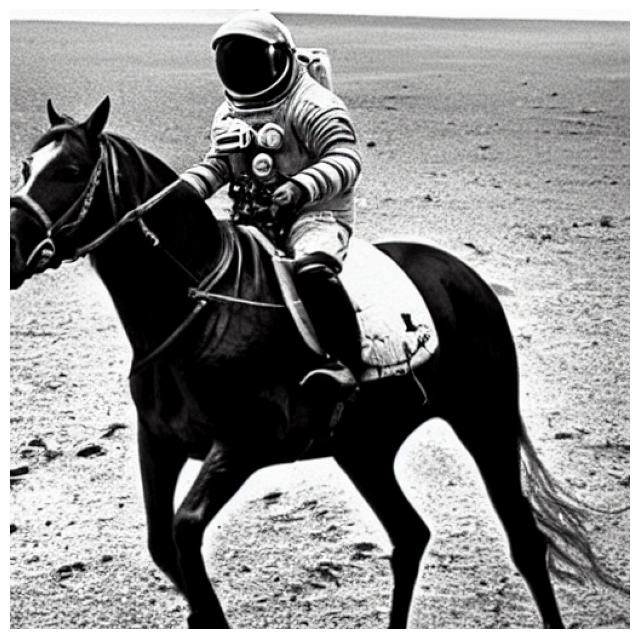

In [12]:
ov_pipeline = StableDiffusion(text_encoder=ov_text_encoder, diffusion_model=ov_diffusion_model, decoder=ov_decoder)

images = ov_pipeline.text_to_image("photograph of an astronaut riding a horse", num_steps=50, seed=80)

plot_images(images)

### Quantization
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.

According to `keras_cv.models.StableDiffusion` structure, the diffusion model takes up significant portion of the overall pipeline execution time. Now we will show you how to optimize the UNet part using [NNCF](https://github.com/openvinotoolkit/nncf/) to reduce computation cost and speed up the pipeline. Quantizing the rest of the pipeline does not significantly improve inference performance but can lead to a substantial degradation of accuracy. That's why we use weight compression for `text_encoder` and `decoder` to reduce memory footprint.

For the diffusion model we apply quantization in hybrid mode which means that we quantize: (1) weights of MatMul and Embedding layers and (2) activations of other layers. The steps are the following:

1. Create a calibration dataset for quantization.
2. Collect operations with weights.
3. Run `nncf.compress_model()` to compress only the model weights.
4. Run `nncf.quantize()` on the compressed model with weighted operations ignored by providing `ignored_scope` parameter.
5. Save the `INT8` model using `openvino.save_model()` function.


Please select below whether you would like to run quantization to improve model inference speed.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take some time.

In [13]:
to_quantize = widgets.Checkbox(
    value=True,
    description="Quantization",
    disabled=False,
)

to_quantize

Checkbox(value=True, description='Quantization')

In [14]:
# Fetch `skip_kernel_extension` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
)
open("skip_kernel_extension.py", "w").write(r.text)

ov_int8_pipeline = None
OV_INT8_DIFFUSION_MODEL_PATH = Path("models/ov_int8_diffusion_model.xml")
OV_INT8_TEXT_ENCODER_MODEL_PATH = Path("models/ov_int8_text_encoder_model.xml")
OV_INT8_DECODER_MODEL_PATH = Path("models/ov_int8_decoder_model.xml")

%load_ext skip_kernel_extension

#### Prepare calibration dataset
[back to top ⬆️](#Table-of-contents:)

We use a portion of [conceptual_captions](https://huggingface.co/datasets/google-research-datasets/conceptual_captions) dataset from Hugging Face as calibration data.
To collect intermediate model inputs for UNet optimization we should customize `CompiledModel`.

In [15]:
%%skip not $to_quantize.value

import datasets
import numpy as np
from tqdm.notebook import tqdm
from typing import Any, Dict, List


class CompiledModelDecorator(ov.CompiledModel):
    def __init__(self, compiled_model: ov.CompiledModel, data_cache: List[Any] = None, keep_prob: float = 0.5):
        super().__init__(compiled_model)
        self.data_cache = data_cache if data_cache is not None else []
        self.keep_prob = keep_prob

    def __call__(self, *args, **kwargs):
        if np.random.rand() <= self.keep_prob:
            self.data_cache.append(*args)
        return super().__call__(*args, **kwargs)


def collect_calibration_data(ov_pipe, calibration_dataset_size: int, num_inference_steps: int = 50) -> List[Dict]:
    original_unet = ov_pipe._diffusion_model
    calibration_data = []
    ov_pipe._diffusion_model = CompiledModelDecorator(original_unet, calibration_data, keep_prob=0.7)

    dataset = datasets.load_dataset("google-research-datasets/conceptual_captions", split="train", streaming=True, trust_remote_code=True).shuffle(seed=42)

    # Run inference for data collection
    pbar = tqdm(total=calibration_dataset_size)
    for batch in dataset:
        prompt = batch["caption"]
        if len(prompt) > MAX_PROMPT_LENGTH:
            continue
        ov_pipe.text_to_image(prompt, num_steps=num_inference_steps, seed=1)
        pbar.update(len(calibration_data) - pbar.n)
        if pbar.n >= calibration_dataset_size:
            break

    ov_pipe._diffusion_model = original_unet
    return calibration_data[:calibration_dataset_size]

In [16]:
%%skip not $to_quantize.value

if not OV_INT8_DIFFUSION_MODEL_PATH.exists() :
    subset_size = 200
    calibration_data = collect_calibration_data(ov_pipeline, calibration_dataset_size=subset_size)

/home/ltalamanova/tmp_venv/lib/python3.11/site-packages/datasets/load.py:1461: FutureWarning: The repository for conceptual_captions contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conceptual_captions
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

50/50 [==============================] - 65s 1s/step


#### Run Quantization
[back to top ⬆️](#Table-of-contents:)

In [17]:
%%skip not $to_quantize.value

from collections import deque

def get_operation_const_op(operation, const_port_id: int):
    node = operation.input_value(const_port_id).get_node()
    queue = deque([node])
    constant_node = None
    allowed_propagation_types_list = ["Convert", "FakeQuantize", "Reshape"]

    while len(queue) != 0:
        curr_node = queue.popleft()
        if curr_node.get_type_name() == "Constant":
            constant_node = curr_node
            break
        if len(curr_node.inputs()) == 0:
            break
        if curr_node.get_type_name() in allowed_propagation_types_list:
            queue.append(curr_node.input_value(0).get_node())

    return constant_node


def is_embedding(node) -> bool:
    allowed_types_list = ["f16", "f32", "f64"]
    const_port_id = 0
    input_tensor = node.input_value(const_port_id)
    if input_tensor.get_element_type().get_type_name() in allowed_types_list:
        const_node = get_operation_const_op(node, const_port_id)
        if const_node is not None:
            return True

    return False


def collect_ops_with_weights(model):
    ops_with_weights = []
    for op in model.get_ops():
        if op.get_type_name() == "MatMul":
            constant_node_0 = get_operation_const_op(op, const_port_id=0)
            constant_node_1 = get_operation_const_op(op, const_port_id=1)
            if constant_node_0 or constant_node_1:
                ops_with_weights.append(op.get_friendly_name())
        if op.get_type_name() == "Gather" and is_embedding(op):
            ops_with_weights.append(op.get_friendly_name())

    return ops_with_weights

In [18]:
%%skip not $to_quantize.value

import nncf
from nncf.quantization.advanced_parameters import AdvancedSmoothQuantParameters

if not OV_INT8_DIFFUSION_MODEL_PATH.exists():
    diffusion_model = core.read_model(OV_DIFFUSION_MODEL_PATH)
    unet_ignored_scope = collect_ops_with_weights(diffusion_model)
    compressed_diffusion_model = nncf.compress_weights(diffusion_model, ignored_scope=nncf.IgnoredScope(types=['Convolution']))
    quantized_diffusion_model = nncf.quantize(
        model=compressed_diffusion_model,
        calibration_dataset=nncf.Dataset(calibration_data),
        subset_size=subset_size,
        model_type=nncf.ModelType.TRANSFORMER,
        ignored_scope=nncf.IgnoredScope(names=unet_ignored_scope),
        advanced_parameters=nncf.AdvancedQuantizationParameters(smooth_quant_alphas=AdvancedSmoothQuantParameters(matmul=-1))
    )
    ov.save_model(quantized_diffusion_model, OV_INT8_DIFFUSION_MODEL_PATH)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino
INFO:nncf:98 ignored nodes were found by types in the NNCFGraph
INFO:nncf:Statistics of the bitwidth distribution:
+--------------+---------------------------+-----------------------------------+
| Num bits (N) | % all parameters (layers) |    % ratio-defining parameters    |
|              |                           |             (layers)              |
+==============+===========================+===================================+
| 8            | 100% (184 / 184)          | 100% (184 / 184)                  |
+--------------+---------------------------+-----------------------------------+


Output()

INFO:nncf:184 ignored nodes were found by name in the NNCFGraph
INFO:nncf:128 ignored nodes were found by name in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 4 diffusion_model/dense_72/MatMul
8 diffusion_model/dense_72/BiasAdd
44 diffusion_model/activation/mul_1

INFO:nncf:Not adding activation input quantizer for operation: 10 diffusion_model/spatial_transformer/basic_transformer_block/cross_attention_1/dense_81/Tensordot/MatMul
INFO:nncf:Not adding activation input quantizer for operation: 11 diffusion_model/spatial_transformer_1/basic_transformer_block_1/cross_attention_3/dense_91/Tensordot/MatMul
INFO:nncf:Not adding activation input quantizer for operation: 12 diffusion_model/spatial_transformer_1/basic_transformer_block_1/cross_attention_3/dense_92/Tensordot/MatMul
INFO:nncf:Not adding activation input quantizer for operation: 13 diffusion_model/spatial_transformer_10/basic_transformer_block_10/cross_attention_21/dense_196/Tensordot/MatMul
INFO:nn

Output()

Output()

#### Run Weight Compression
[back to top ⬆️](#Table-of-contents:)

Quantizing of the `text encoder` and `decoder` does not significantly improve inference performance but can lead to a substantial degradation of accuracy. The weight compression will be applied to footprint reduction.

In [19]:
%%skip not $to_quantize.value

if not OV_INT8_TEXT_ENCODER_MODEL_PATH.exists():
    text_encoder_model = core.read_model(OV_TEXT_ENCODER_MODEL_PATH)
    compressed_text_encoder_model = nncf.compress_weights(text_encoder_model)
    ov.save_model(compressed_text_encoder_model, OV_INT8_TEXT_ENCODER_MODEL_PATH)

if not OV_INT8_DECODER_MODEL_PATH.exists():
    decoder_model = core.read_model(OV_DECODER_MODEL_PATH)
    compressed_decoder_model = nncf.compress_weights(decoder_model)
    ov.save_model(compressed_decoder_model, OV_INT8_DECODER_MODEL_PATH)

INFO:nncf:Statistics of the bitwidth distribution:
+--------------+---------------------------+-----------------------------------+
| Num bits (N) | % all parameters (layers) |    % ratio-defining parameters    |
|              |                           |             (layers)              |
+==============+===========================+===================================+
| 8            | 100% (74 / 74)            | 100% (74 / 74)                    |
+--------------+---------------------------+-----------------------------------+


Output()

INFO:nncf:Statistics of the bitwidth distribution:
+--------------+---------------------------+-----------------------------------+
| Num bits (N) | % all parameters (layers) |    % ratio-defining parameters    |
|              |                           |             (layers)              |
+==============+===========================+===================================+
| 8            | 100% (40 / 40)            | 100% (40 / 40)                    |
+--------------+---------------------------+-----------------------------------+


Output()

Let's compare the images generated by the original and optimized pipelines.

In [20]:
%%skip not $to_quantize.value

ov_int8_text_encoder = core.compile_model(OV_INT8_TEXT_ENCODER_MODEL_PATH, device.value)
ov_int8_diffusion_model = core.compile_model(OV_INT8_DIFFUSION_MODEL_PATH, device.value)
ov_int8_decoder = core.compile_model(OV_INT8_DECODER_MODEL_PATH, device.value)

ov_int8_pipeline = StableDiffusion(
    text_encoder=ov_int8_text_encoder, diffusion_model=ov_int8_diffusion_model, decoder=ov_int8_decoder,
)

int8_image = ov_int8_pipeline.text_to_image(
    "photograph of an astronaut riding a horse",
    num_steps=50,
    seed=80
)[0]

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
50/50 [==============================] - 39s 785ms/step


In [21]:
%%skip not $to_quantize.value

import matplotlib.pyplot as plt

def visualize_results(orig_img, optimized_img):
    """
    Helper function for results visualization

    Parameters:
       orig_img (Image.Image): generated image using FP16 models
       optimized_img (Image.Image): generated image using quantized models
    Returns:
       fig (matplotlib.pyplot.Figure): matplotlib generated figure contains drawing result
    """
    orig_title = "FP16 pipeline"
    control_title = "INT8 pipeline"
    figsize = (20, 20)
    fig, axs = plt.subplots(1, 2, figsize=figsize, sharex='all', sharey='all')
    list_axes = list(axs.flat)
    for a in list_axes:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        a.grid(False)
    list_axes[0].imshow(np.array(orig_img))
    list_axes[1].imshow(np.array(optimized_img))
    list_axes[0].set_title(orig_title, fontsize=15)
    list_axes[1].set_title(control_title, fontsize=15)

    fig.subplots_adjust(wspace=0.01, hspace=0.01)
    fig.tight_layout()
    return fig

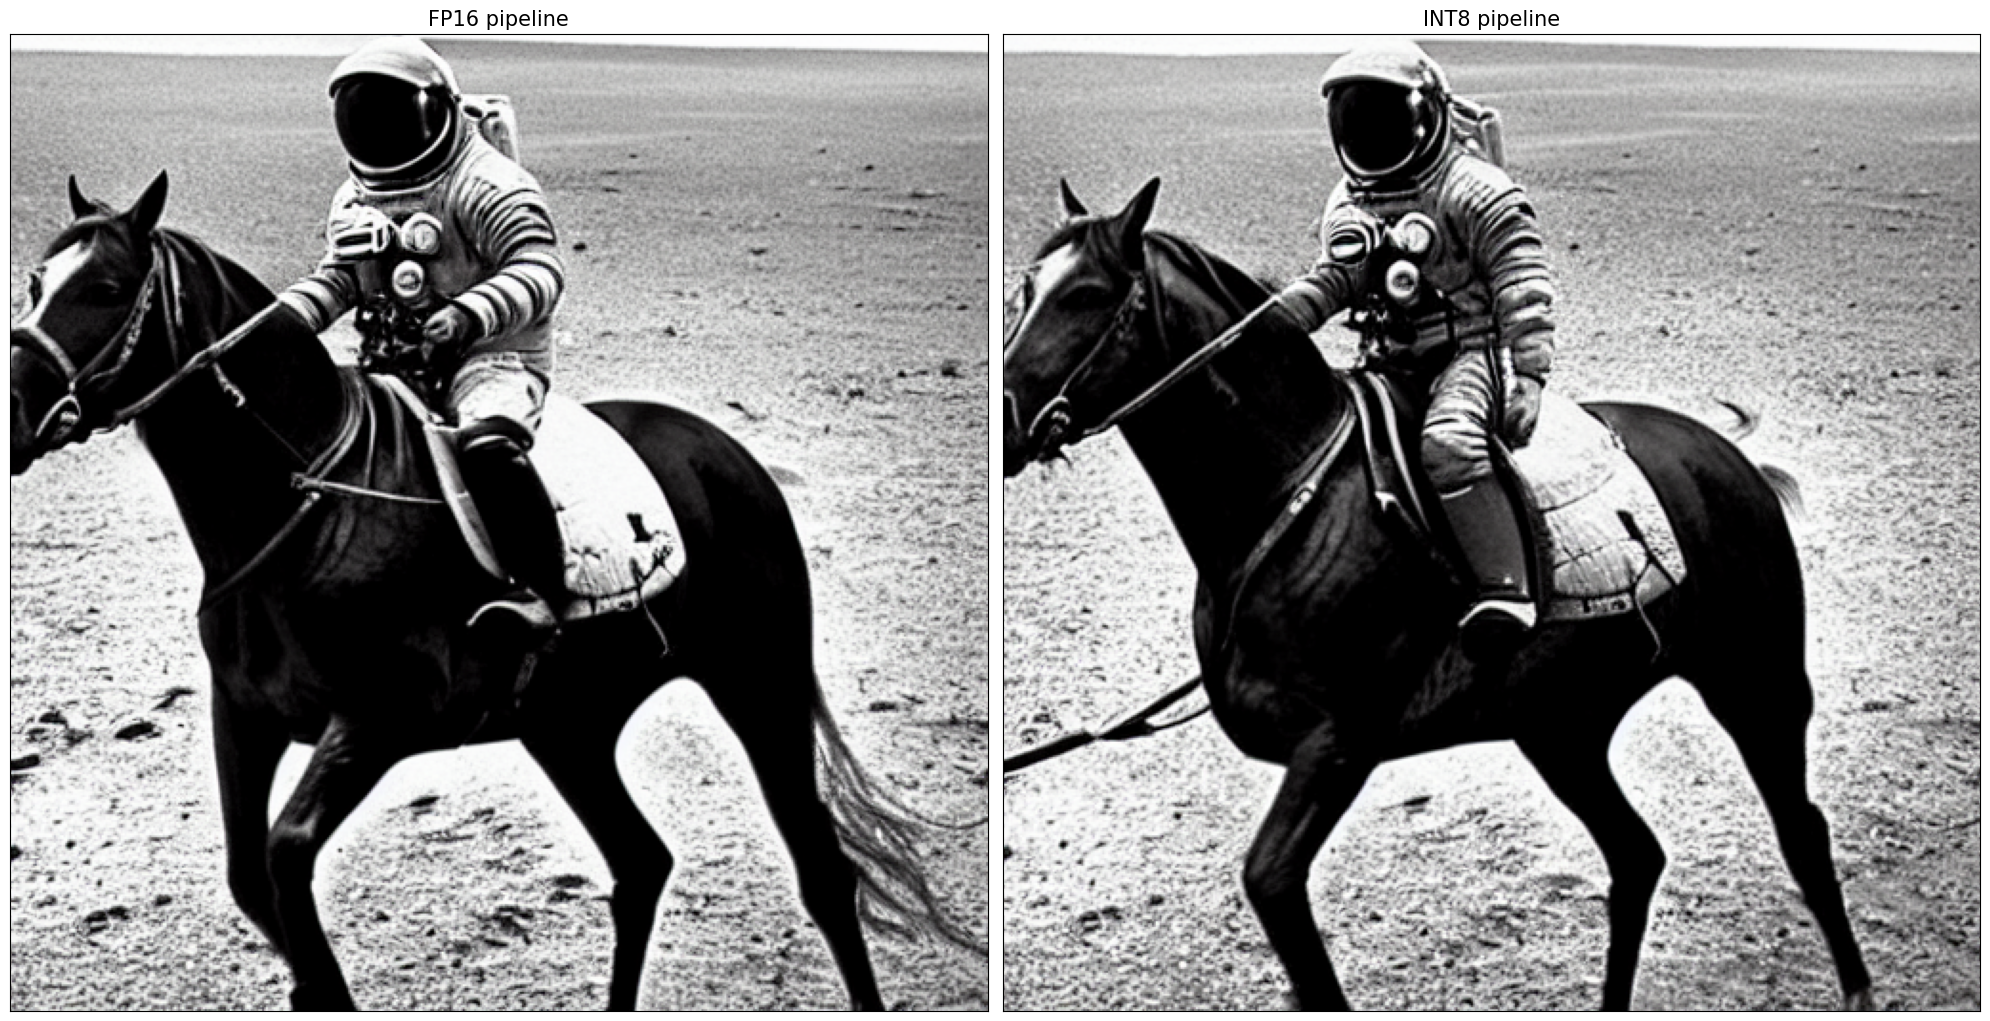

In [22]:
%%skip not $to_quantize.value

visualize_results(images[0], int8_image)

### Compare model file sizes

[back to top ⬆️](#Table-of-contents:)

In [23]:
%%skip not $to_quantize.value

fp16_model_paths = [OV_TEXT_ENCODER_MODEL_PATH, OV_DIFFUSION_MODEL_PATH, OV_DECODER_MODEL_PATH]
int8_model_paths = [OV_INT8_TEXT_ENCODER_MODEL_PATH, OV_INT8_DIFFUSION_MODEL_PATH, OV_INT8_DECODER_MODEL_PATH]

for fp16_path, int8_path in zip(fp16_model_paths, int8_model_paths):
    fp16_ir_model_size = fp16_path.with_suffix(".bin").stat().st_size
    int8_model_size = int8_path.with_suffix(".bin").stat().st_size
    print(f"{fp16_path.stem} compression rate: {fp16_ir_model_size / int8_model_size:.3f}")

ov_text_encoder_model compression rate: 1.992
ov_diffusion_model compression rate: 1.997
ov_decoder_model compression rate: 1.997


### Compare inference time of the FP16 and INT8 pipelines
[back to top ⬆️](#Table-of-contents:)

To measure the inference performance of the `FP16` and `INT8` pipelines, we use median inference time on calibration subset.

> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications.

In [24]:
%%skip not $to_quantize.value

import time

def calculate_inference_time(pipeline, validation_data):
    inference_time = []
    for prompt in validation_data:
        start = time.perf_counter()
        _ = pipeline.text_to_image(prompt, num_steps=50, seed=1)
        end = time.perf_counter()
        delta = end - start
        inference_time.append(delta)
    return np.median(inference_time)

In [25]:
%%skip not $to_quantize.value

validation_size = 3
validation_dataset = datasets.load_dataset("google-research-datasets/conceptual_captions", split="train", streaming=True, trust_remote_code=True).take(validation_size)
validation_data = [batch["caption"] for batch in validation_dataset]

fp_latency = calculate_inference_time(ov_pipeline, validation_data)
int8_latency = calculate_inference_time(ov_int8_pipeline, validation_data)
print(f"Performance speed-up: {fp_latency / int8_latency:.3f}")

/home/ltalamanova/tmp_venv/lib/python3.11/site-packages/datasets/load.py:1461: FutureWarning: The repository for conceptual_captions contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conceptual_captions
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


50/50 [==============================] - 39s 784ms/step
Performance speed-up: 1.628


### Interactive Demo

[back to top ⬆️](#Table-of-contents:)

Please select below whether you would like to use the quantized model to launch the interactive demo.

In [26]:
use_quantized_model = widgets.Checkbox(
    description="Use quantized model",
    value=ov_int8_pipeline is not None,
    disabled=ov_int8_pipeline is None,
)

use_quantized_model

Checkbox(value=True, description='Use quantized model')

In [ ]:
import gradio as gr


pipeline = ov_int8_pipeline if use_quantized_model.value else ov_pipeline


def generate(text, seed, steps):
    return pipeline.text_to_image(text, num_steps=steps, seed=seed)[0]


demo = gr.Interface(
    generate,
    [
        gr.Textbox(lines=3, label="Text"),
        gr.Slider(0, 10000000, value=45, label="Seed"),
        gr.Slider(1, 50, value=25, step=1, label="Steps"),
    ],
    gr.Image(label="Result"),
    examples=[
        ["photograph of an astronaut riding a horse", 80, 25],
        ["photograph of a cat", 45, 25],
    ],
    allow_flagging="never",
)

try:
    demo.launch(debug=True, height=1000)
except Exception:
    demo.launch(share=True, debug=True, height=1000)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/